In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def prey_poblation(a: float, b: float, p: int, P: int) -> float:
    return (a * p) - (b * p * P)

def prey_poblation_log(a: float, b: float, p: int, P: int, K: int) -> float:
    return (a * p * (1 - (p/K))) - (b * p * P)

def depr_poblation(b: float, m: float, p: int, P: int, eps: float) -> float:
    return (eps * b * p * P) - (m * P)

def lotka_volterra(t: float, y: list[float], params: dict) -> list[float]:
    p, P = y
    a, b, m, eps = params['a'], params['b'], params['m'], params['eps']

    dpdt = prey_poblation(a, b, p, P)
    dPdt = depr_poblation(b, m, p, P, eps)

    return [dpdt, dPdt]

def lotka_volterra_log(t: float, y: list[float], params: dict) -> list[float]:
    p, P = y
    a, b, m, eps, K = params['a'], params['b'], params['m'], params['eps'], params['K']

    dpdt = prey_poblation_log(a, b, p, P, K)
    dPdt = depr_poblation(b, m, p, P, eps)

    return [dpdt, dPdt]

def rk4_step(f: Callable, t: float, y: list[float], dt: float, params: dict) -> list[float]:
    k1 = [dt * val for val in f(t, y, params)]
    k2 = [dt * val for val in f(t + (dt/2), [y[i] + (k1[i]/2) for i in range(len(y))], params)]
    k3 = [dt * val for val in f(t + (dt/2), [y[i] + (k2[i]/2) for i in range(len(y))], params)]
    k4 = [dt * val for val in f(t + dt, [y[i] + k3[i]for i in range(len(y))], params)]

    return [y[i] + ((k1[i] + 2*k2[i] + 2*k3[i] + k4[i]) / 6) for i in range(len(y))]

In [3]:
params = {
  'a': 0.05,
  'b': 0.003,
  'm': 0.01,
  'eps': 0.02,
  'K': 1_500
}

p0, P0 = 40, 25
y = [p0, P0]

dt = 0.01
T = 50_000
steps = int(T/dt)

times = []
prey = []
predators = []

t = 0
for _ in range(steps):
    times.append(t)
    prey.append(y[0])
    predators.append(y[1])

    y = rk4_step(lotka_volterra, t, y, dt, params)
    t += dt

R_e = params['m'] / (params['eps'] * params['b'])
F_e = params['a'] / params['b']

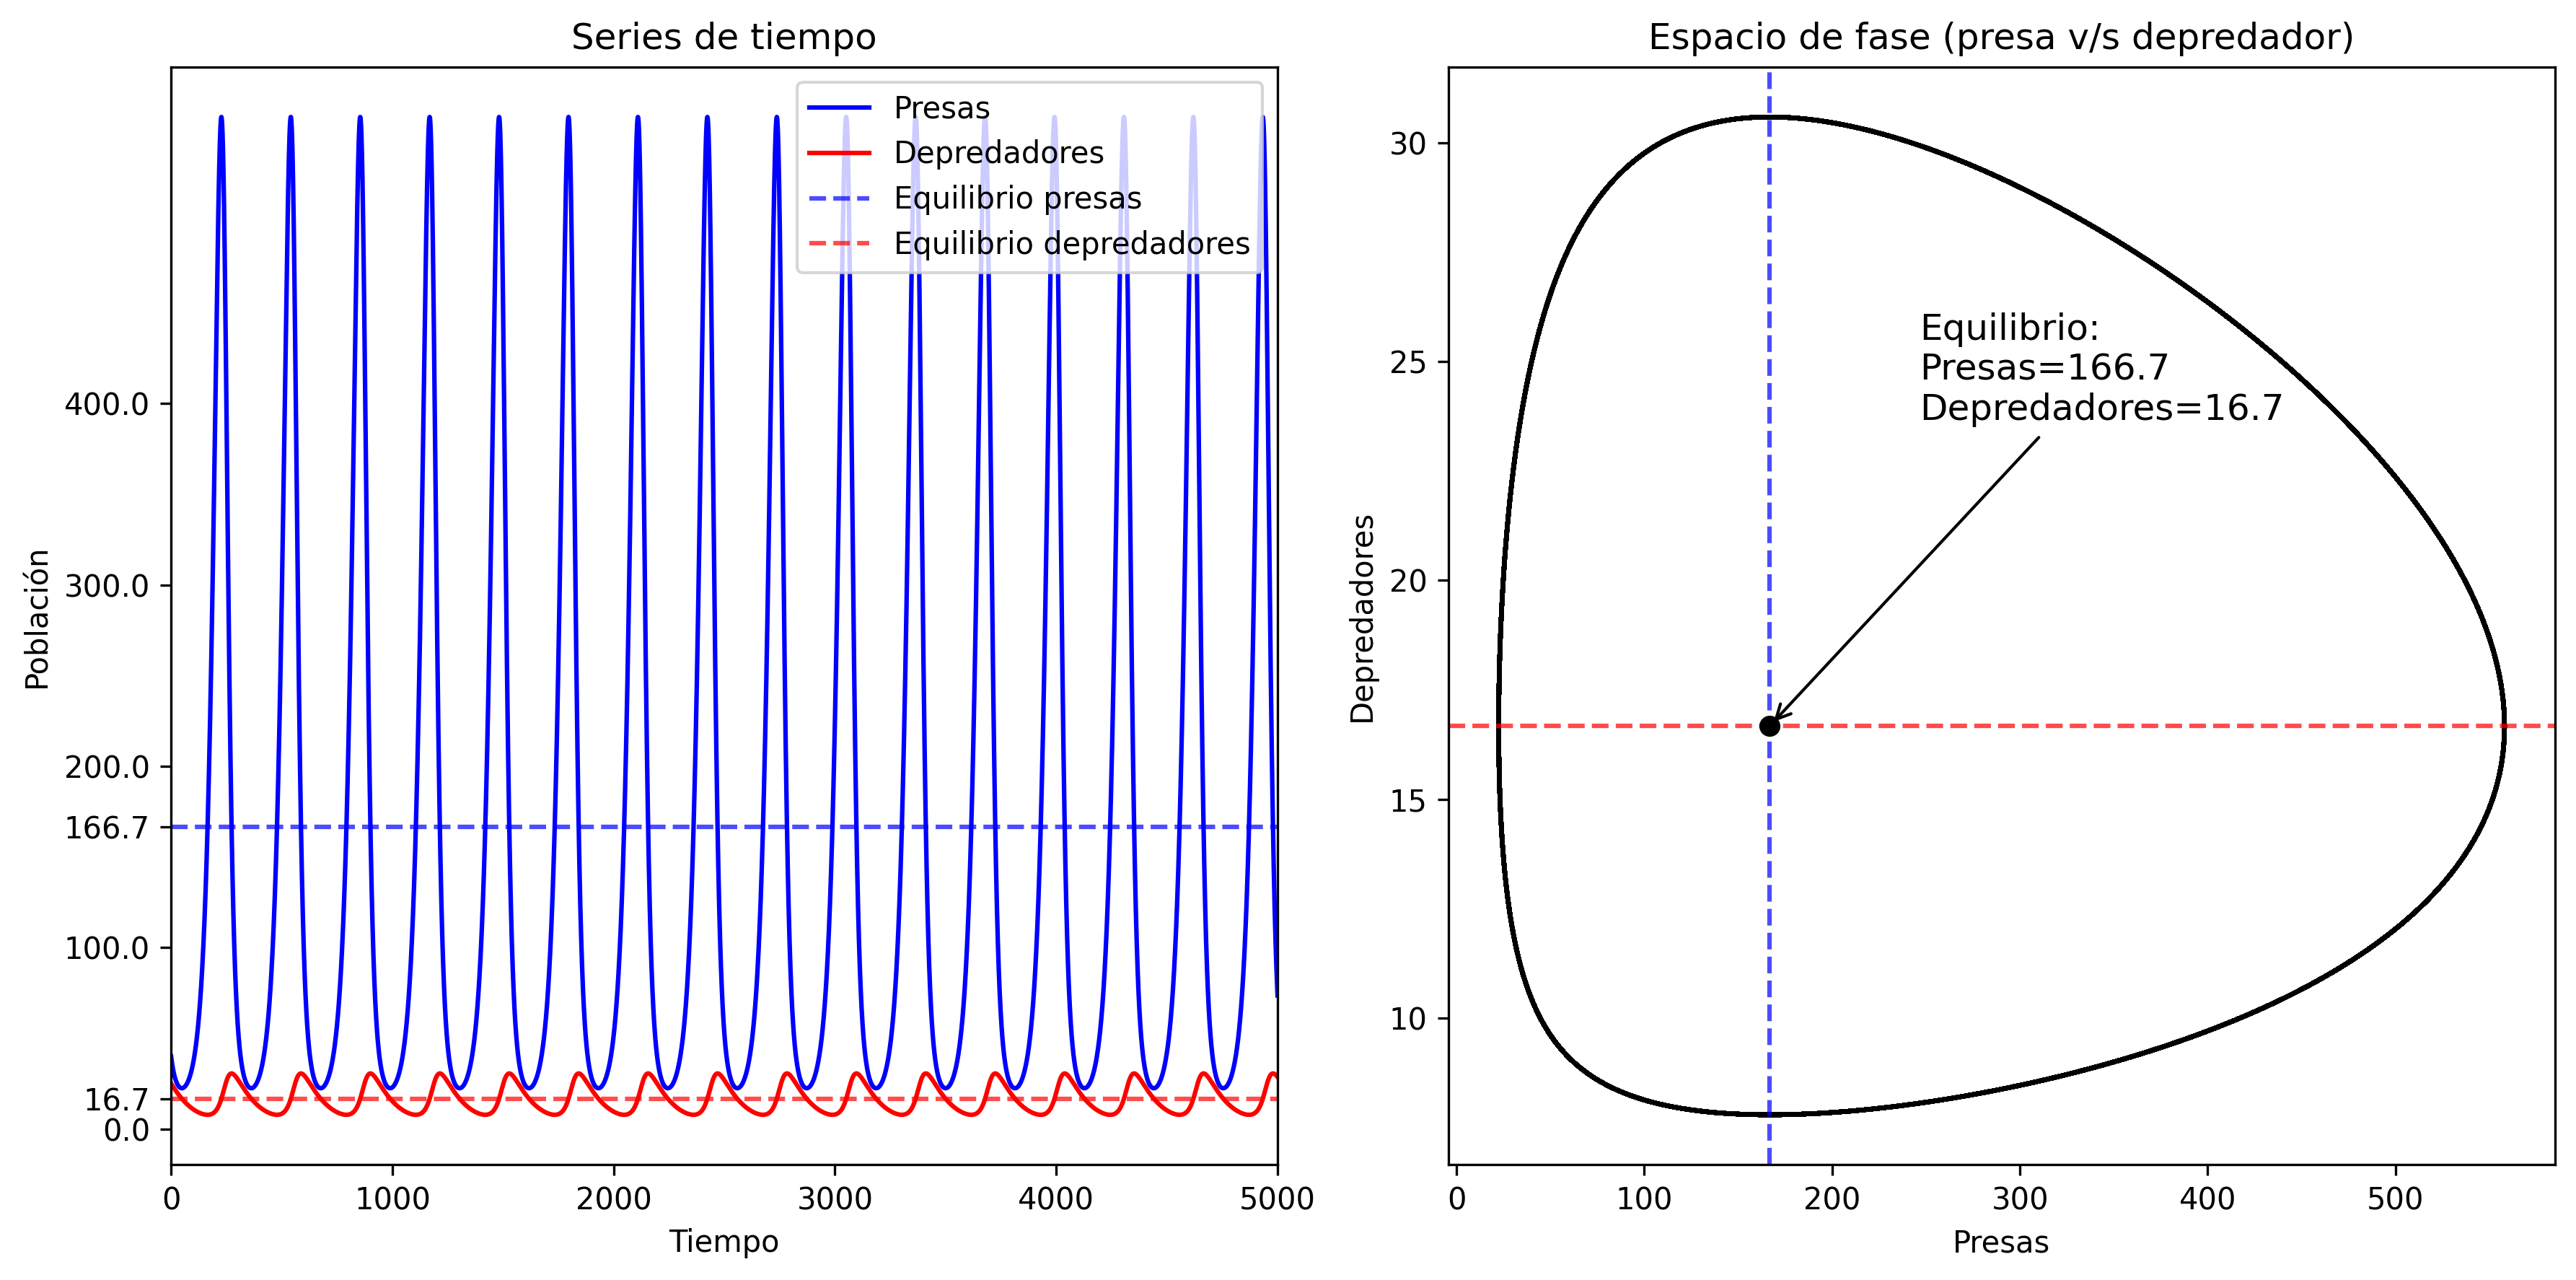

In [4]:
plt.figure(figsize=(12, 6), dpi=150)
plt.subplot(1, 2, 1)
plt.plot(times, prey, label='Presas', color='blue')
plt.plot(times, predators, label='Depredadores', color='red')
plt.yticks([0, 100, 200, 300, 400, F_e, R_e,])
plt.axhline(y=R_e, color='blue', linestyle='--', alpha=0.7, label='Equilibrio presas')
plt.axhline(y=F_e, color='red', linestyle='--', alpha=0.7, label='Equilibrio depredadores')
plt.xlabel('Tiempo')
plt.xlim(0, 5_000)
plt.ylabel('Población')
plt.legend(loc='upper right')
plt.title('Series de tiempo')

plt.subplot(1, 2, 2)
plt.plot(prey, predators, color='black')
plt.axvline(x=R_e, color='blue', linestyle='--', alpha=0.7, label='Equilibrio presas')
plt.axhline(y=F_e, color='red', linestyle='--', alpha=0.7, label='Equilibrio depredadores')
plt.scatter(R_e, F_e, color='black', zorder=5)
plt.annotate(f"Equilibrio:\nPresas={R_e:.1f}\nDepredadores={F_e:.1f}",
             xy=(R_e, F_e), xytext=(R_e+80, F_e+7), fontsize=12,
             arrowprops=dict(arrowstyle="->", color="black"))
plt.xlabel('Presas')
plt.ylabel('Depredadores')  
plt.title('Espacio de fase (presa v/s depredador)')

plt.tight_layout() 
plt.show();

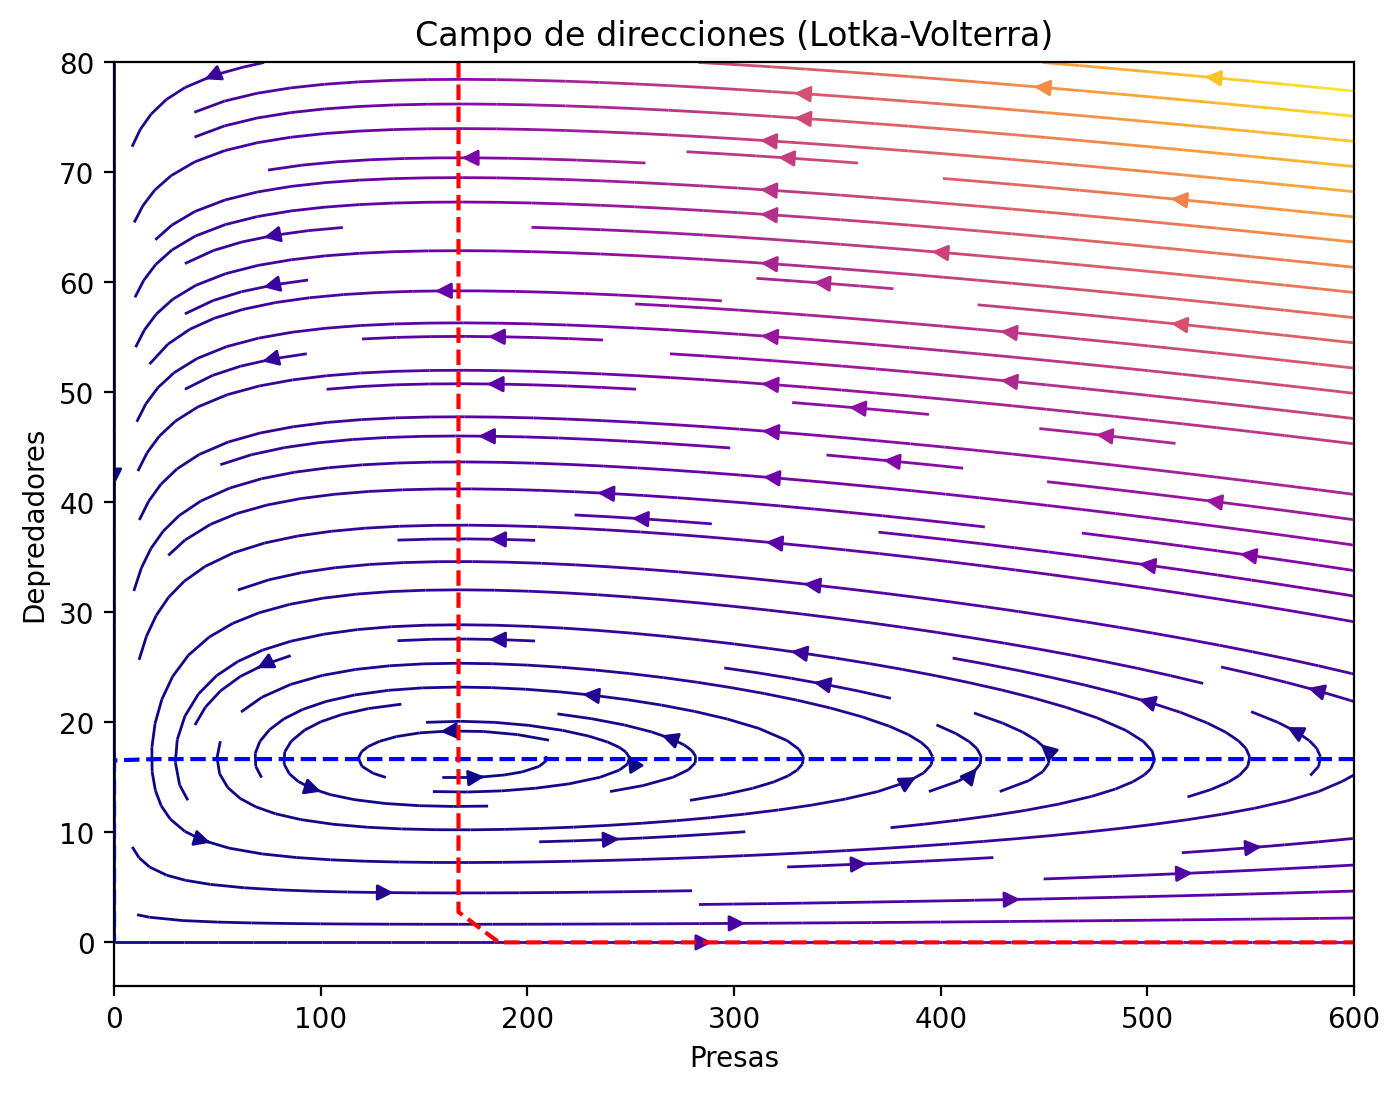

In [5]:
# Define grid for phase space
p_vals = np.linspace(0, 600, 30)
P_vals = np.linspace(0, 80, 30)

p_grid, P_grid = np.meshgrid(p_vals, P_vals)

# Compute derivatives at each grid point
dpdt = np.zeros_like(p_grid)
dPdt = np.zeros_like(P_grid)
for i in range(p_grid.shape[0]):
	for j in range(p_grid.shape[1]):
		dpdt[i, j] = prey_poblation(params['a'], params['b'], p_grid[i, j], P_grid[i, j])
		dPdt[i, j] = depr_poblation(params['b'], params['m'], p_grid[i, j], P_grid[i, j], params['eps'])

speed = np.sqrt(dpdt**2 + dPdt**2)

plt.figure(figsize=(8, 6))
plt.streamplot(p_grid, P_grid, dpdt, dPdt, 
			   color=speed, cmap='plasma', density=1.2,
			   linewidth=1, arrowsize=1.2)
plt.contour(p_grid, P_grid, dpdt, levels=[0], colors='blue', linestyles='dashed')
plt.contour(p_grid, P_grid, dPdt, levels=[0], colors='red', linestyles='dashed')

plt.xlabel('Presas')
plt.ylabel('Depredadores')
plt.title('Campo de direcciones (Lotka-Volterra)')
plt.show();

In [6]:
params_log = {
  'a': 0.05,
  'b': 0.003,
  'm': 0.01,
  'eps': 0.02,
  'K': 1_500
}

p0_log, P0_log = 40, 25
y_log = [p0_log, P0_log]

dt_log = 0.01
T_log = 50_000
steps = int(T_log/dt_log)

times_log = []
prey_log = []
predators_log = []

t_log = 0
for _ in range(steps):
    times_log.append(t_log)
    prey_log.append(y_log[0])
    predators_log.append(y_log[1])

    y_log = rk4_step(lotka_volterra_log, t_log, y_log, dt_log, params_log)
    t_log += dt_log

R_e_log = params_log['m'] / (params_log['b'] * params_log['eps'])
F_e_log = (params_log['a'] / params_log['b']) * (1 - R_e / params_log['K'])

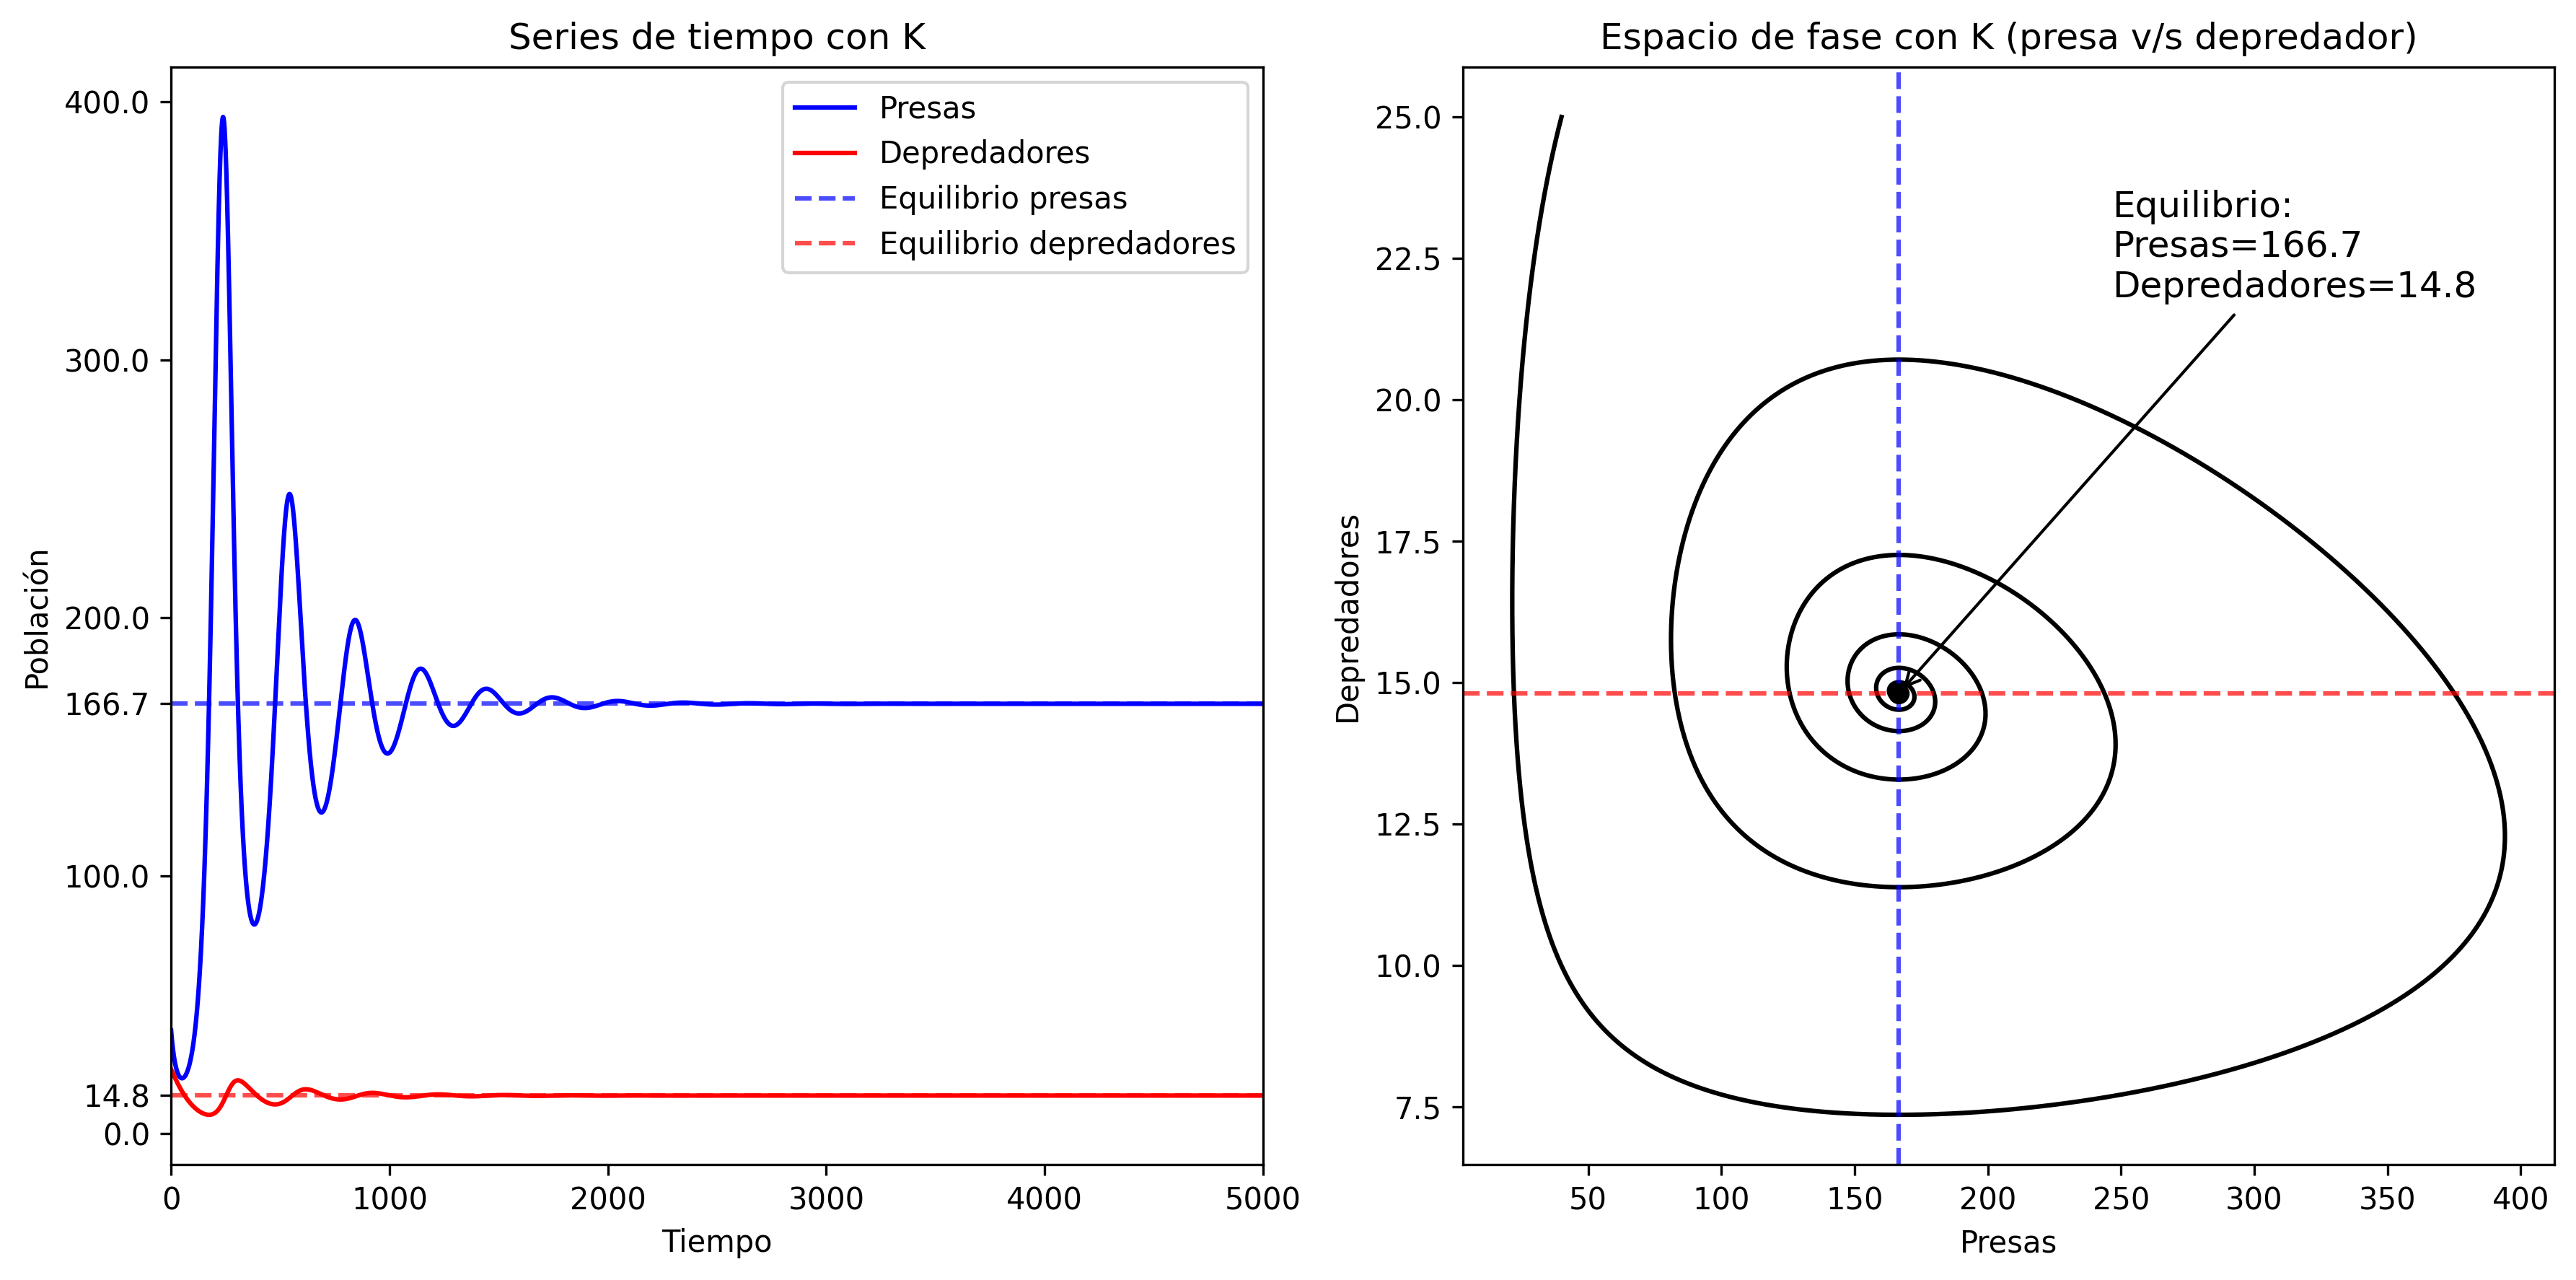

In [7]:
plt.figure(figsize=(12, 6), dpi=150)
plt.subplot(1, 2, 1)
plt.plot(times_log, prey_log, label='Presas', color='blue')
plt.plot(times_log, predators_log, label='Depredadores', color='red')
plt.yticks([0, 100, 200, 300, 400, F_e_log, R_e_log,])
plt.axhline(y=R_e_log, color='blue', linestyle='--', alpha=0.7, label='Equilibrio presas')
plt.axhline(y=F_e_log, color='red', linestyle='--', alpha=0.7, label='Equilibrio depredadores')
plt.xlabel('Tiempo')
plt.xlim(0, 5_000)
plt.ylabel('Población')
plt.legend(loc='upper right')
plt.title('Series de tiempo con K')

plt.subplot(1, 2, 2)
plt.plot(prey_log, predators_log, color='black')
plt.axvline(x=R_e_log, color='blue', linestyle='--', alpha=0.7, label='Equilibrio presas')
plt.axhline(y=F_e_log, color='red', linestyle='--', alpha=0.7, label='Equilibrio depredadores')
plt.scatter(R_e_log, F_e_log, color='black', zorder=5)
plt.annotate(f"Equilibrio:\nPresas={R_e_log:.1f}\nDepredadores={F_e_log:.1f}",
             xy=(R_e_log, F_e_log), xytext=(R_e_log+80, F_e_log+7), fontsize=12,
             arrowprops=dict(arrowstyle="->", color="black"))
plt.xlabel('Presas')
plt.ylabel('Depredadores')
plt.title('Espacio de fase con K (presa v/s depredador)')

plt.tight_layout() 
plt.show();